In [1]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
seed = 95956
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  95956


In [2]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system names
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

matplotlib==3.5.0
numpy==1.19.5
torch==1.9.1
torchvision==0.10.1


In [3]:
# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
dataroot = "../input/"

# Number of workers for dataloader
workers = 2

batch_size = 128
image_size = 64

# num_channels
nc = 3

num_epochs = 50
ngpu = 1

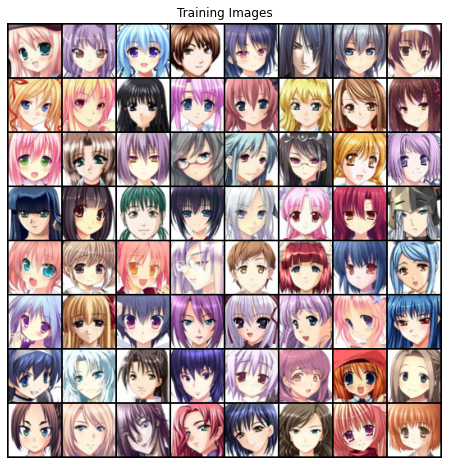

In [5]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size), # this resizes the images to 64/64
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( 100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (64*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (64*4) x 8 x 8
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (64*2) x 16 x 16
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (64) x 32 x 32
            nn.ConvTranspose2d( 64, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the generator
gan_generator = Generator(ngpu).to(device)

# Randomly initialize all weights, mean=0, stdev=0.2
gan_generator.apply(weights_init)

# Print the model
print(gan_generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
# Create the Discriminator
gan_discriminator = Discriminator(ngpu).to(device)

# Randomly initialize all weights, mean=0, stdev=0.2
gan_discriminator.apply(weights_init)

# Print the model
print(gan_discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Training

### Loss functions and Optimizers

In [11]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, 100, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
lr = 0.0002
beta_adam = 0.5
optimizerD = optim.Adam(gan_discriminator.parameters(), lr=lr, betas=(beta_adam, 0.999))
optimizerG = optim.Adam(gan_generator.parameters(), lr=lr, betas=(beta_adam, 0.999))

### Begin training

In [12]:
# Training Loop

img_list = []
G_losses = []
D_losses = []
iters = 0
real_label = 1
fake_label = 0

for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        gan_discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        label = torch.full((real_cpu.size(0),), real_label, device=device)

        # Forward pass real batch through D, we will train D on both real and fake data
        output = gan_discriminator(real_cpu).view(-1)
        # print(gan_discriminator(real_cpu).shape)
        errD_real = criterion(output, label.float())
        errD_real.backward()

        # Train with fake batch
        noise = torch.randn(real_cpu.size(0), input_size, 1, 1, device=device)
        fake = gan_generator(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = gan_discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label.float())
        errD_fake.backward()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update generator with log(D(G(z)))
        gan_generator.zero_grad()
        label.fill_(real_label)
        
        output = gan_discriminator(fake).view(-1)
        errG = criterion(output, label.float())
        errG.backward()
        optimizerG.step()

        # Output training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader), errD.item(), errG.item()))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 250 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gan_generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/50][0/497]	Loss_D: 1.8535	Loss_G: 3.7350	D(x): 0.4313	D(G(z)): 0.5149 / 0.0385
[1/50][0/497]	Loss_D: 0.3988	Loss_G: 6.6707	D(x): 0.7476	D(G(z)): 0.0209 / 0.0032
[2/50][0/497]	Loss_D: 0.4288	Loss_G: 5.5281	D(x): 0.9395	D(G(z)): 0.2695 / 0.0068
[3/50][0/497]	Loss_D: 0.3794	Loss_G: 4.2304	D(x): 0.8344	D(G(z)): 0.0872 / 0.0210
[4/50][0/497]	Loss_D: 0.1179	Loss_G: 6.3353	D(x): 0.9434	D(G(z)): 0.0458 / 0.0048
[5/50][0/497]	Loss_D: 0.6388	Loss_G: 7.9461	D(x): 0.9310	D(G(z)): 0.3815 / 0.0008
[6/50][0/497]	Loss_D: 0.3542	Loss_G: 5.5679	D(x): 0.9082	D(G(z)): 0.1805 / 0.0080
[7/50][0/497]	Loss_D: 0.3195	Loss_G: 4.0829	D(x): 0.8094	D(G(z)): 0.0557 / 0.0287
[8/50][0/497]	Loss_D: 0.5248	Loss_G: 2.9431	D(x): 0.7010	D(G(z)): 0.0842 / 0.0868
[9/50][0/497]	Loss_D: 0.2271	Loss_G: 3.7313	D(x): 0.8996	D(G(z)): 0.0945 / 0.0437
[10/50][0/497]	Loss_D: 0.4577	Loss_G: 1.9344	D(x): 0.7182	D(G(z)): 0.0652 / 0.2005
[11/50][0/497]	Loss_D: 1.5309	Loss_G: 8.5423	D(x): 0.9942	D(G(z)): 0.68

In [13]:
torch.save(gan_generator.state_dict(), 'generator.pth')
torch.save(gan_discriminator.state_dict(), 'discriminator.pth')

In [14]:
gan_generator = Generator(ngpu).to(device)
gan_generator.load_state_dict(torch.load('generator.pth'))

<All keys matched successfully>

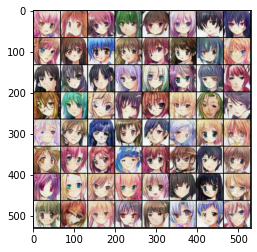

In [15]:
with torch.no_grad():
    fake = gan_generator(fixed_noise).detach().cpu()
 
show = vutils.make_grid(fake, padding=2, normalize=True)
plt.imshow(np.transpose(show,(1,2,0)))

# Results

### Loss plot

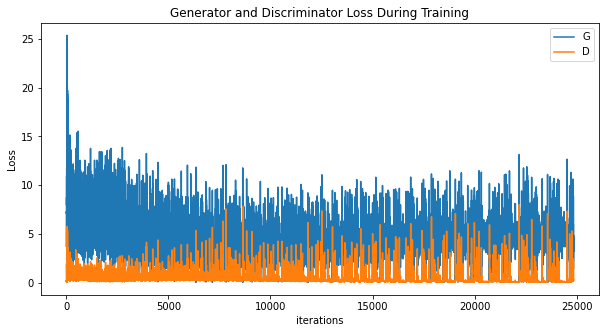

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Training process

# Final Results

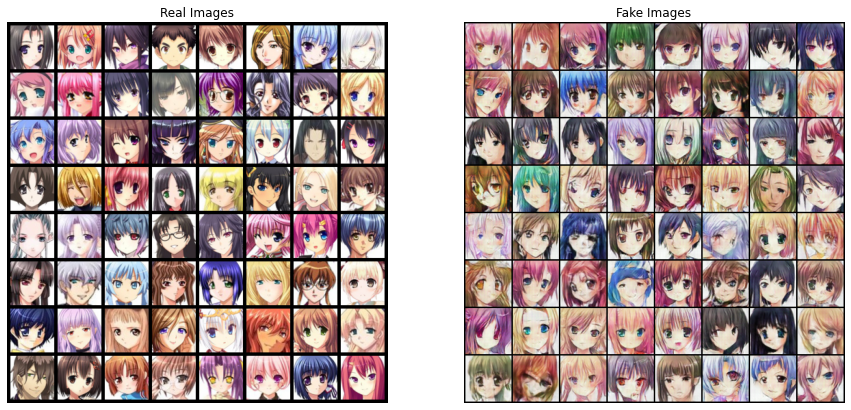

In [18]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()